In [1]:
import numpy as np
import scipy.io as sio
import opensmile
import audiofile

In [2]:
def pad(x, seglen, mode='constant'):
    pad_len = seglen - x.shape[1]
    y = np.pad(x, pad_width=((0, 0), (0, pad_len)), mode=mode)
    return y

def segment(x, seglen=100):
    '''
    :param x: npy形式的mel [80,L]
    :param seglen: padding长度
    :return: padding mel
    '''
    ## 该函数将melspec [80,len] ，padding到固定长度 seglen
    if x.shape[1] < seglen:
        y = pad(x, seglen)
    elif x.shape[1] == seglen:
        y = x
    else:
        r = np.random.randint(x.shape[1] - seglen) ## r : [0-  (L-128 )]
        y = x[:,r:r+seglen]
    return y

In [4]:
loadData = np.load('feature_set_1\healthy\healthy-female-153-a_l.npy')
Melspec=segment(loadData,seglen=100)

data=sio.loadmat('audios_and_mats\healthy\healthy-female-153-a_l.mat')
print(type(data)) #显示mat的数据类型
print(list(data)) #只显示mat包含的属性
## 明天加上看看有没有H1-H2的数据这样正好各四个特征
H1A1C = data["H1A1c"].T #显示属性值#
H1A2C = data["H1A2c"].T #显示属性值#
H1A3C = data["H1A3c"].T #显示属性值#
spectral_tilts = np.concatenate((H1A1C, H1A2C,H1A3C), axis=0)
spectral_tilts[np.isnan(spectral_tilts)] = 0
spectral_tilts = segment(spectral_tilts, seglen=100)

CPP = data["CPP"].T #显示属性值#
CPP[np.isnan(CPP)] = 0
CPP = segment(CPP, seglen=100)

<class 'dict'>
['__header__', '__version__', '__globals__', 'Fs', 'strF0', 'sF1', 'sF2', 'sF3', 'sF4', 'sB1', 'sB2', 'sB3', 'sB4', 'preemphasis', 'A1', 'A2', 'A3', 'AFMTalgorithm', 'H1', 'H2', 'H4', 'HF0algorithm', 'CPP', 'HNR05', 'HNR15', 'HNR25', 'HNR35', 'H1H2c', 'H2H4c', 'BandwidthMethod', 'H1A1c', 'H1A2c', 'H1A3c', 'windowsize', 'frameshift', 'epoch', 'soe']


In [11]:
from sklearn.preprocessing import StandardScaler

def normalize_frames(m,Scale=True):
    if Scale:
        return (m - np.mean(m, axis=0)) / (np.std(m, axis=0) + 2e-12)
    else:
        return (m - np.mean(m, axis=0))

signal, sampling_rate = audiofile.read('audios_and_mats\healthy\healthy-female-153-a_l.wav')
smile = opensmile.Smile(feature_set=opensmile.FeatureSet.eGeMAPSv02,feature_level=opensmile.FeatureLevel.LowLevelDescriptors)
feature = smile.process_signal(signal,sampling_rate)
jitter = feature['jitterLocal_sma3nz']
jitter = jitter.to_numpy().reshape(1,-1)
shimmer = feature['shimmerLocaldB_sma3nz']
shimmer = shimmer.to_numpy().reshape(1,-1)
HNR = feature['HNRdBACF_sma3nz']
HNR = HNR.to_numpy().reshape(1,-1)
#合并多个ndarry
voicing_parms = np.concatenate((jitter,shimmer,HNR),axis=0)
voicing_parms = segment(voicing_parms, seglen=100)
voicing_parms = np.concatenate((voicing_parms,CPP),axis=0)

feature_set_1 = Melspec
feature_set_2 = np.concatenate((Melspec,spectral_tilts),axis=0)
feature_set_3 = np.concatenate((Melspec,voicing_parms),axis=0)
feature_set_4 = np.concatenate((Melspec,spectral_tilts,voicing_parms),axis=0)
scaler = StandardScaler()
feature_set_1_scaled = scaler.fit_transform(feature_set_1)
feature_set_2_scaled = scaler.fit_transform(feature_set_2)
feature_set_3_scaled = scaler.fit_transform(feature_set_3)
feature_set_4_scaled = scaler.fit_transform(feature_set_4)

np.save('feature_set_1\healthy\healthy-female-153-a_l.npy', feature_set_1)
np.save('feature_set_2\healthy\healthy-female-153-a_l.npy', feature_set_2)
np.save('feature_set_3\healthy\healthy-feamle-153-a_l.npy', feature_set_3)
np.save('feature_set_4\healthy\healthy-female-153-a_l.npy', feature_set_4)

In [19]:
from pathlib import Path
from hparms import Processor_Hparams
import warnings
import os
warnings.filterwarnings('ignore')

def extract_mel_feature(hp:Processor_Hparams):
    src_wavp = Path(hp.wav_dir_name)    
    for x in src_wavp.rglob('*'):
        if x.is_dir():
            Path(str(x.resolve()).replace(hp.wav_dir_name,hp.feature_dir_name)).mkdir(parents=True,exist_ok=True)
    print(src_wavp)
    ########################################################################################
    wavpaths = [ x  for x in src_wavp.rglob('*.wav') if x.is_file() ]
    ttsum = len(wavpaths) # 总语音数量
    print('total wav files: ', ttsum)
    mel_frames = []
    k = 0

wav_datadir_name = 'test_audios'
feature_dir_name = 'test_outputs'
preprocess_hp = Processor_Hparams() 
preprocess_hp.set_dir(wav_datadir_name, feature_dir_name)
extract_mel_feature(preprocess_hp)

test_audios
total wav files:  12


In [4]:
import os
import librosa
import warnings
import numpy as np
import scipy.io as sio
from hparms import Processor_Hparams
warnings.filterwarnings('ignore')

def pad(x, seglen, mode='constant'):
    '''
    :param x: ndarry [D,T]
    :param seglen: padding长度
    :param mode: padding模式
    '''
    pad_len = seglen - x.shape[1]
    y = np.pad(x, pad_width=((0, 0), (0, pad_len)), mode=mode)
    return y

def segment(x, seglen=100):
    '''
    :param x: ndarry [D,T]
    :param seglen: padding长度
    :return: padding ndarry [D,seglen]
    '''
    ## 该函数将melspec [80,len] ，padding到固定长度 seglen
    if x.shape[1] < seglen:
        y = pad(x, seglen)
    elif x.shape[1] == seglen:
        y = x
    else:
        r = np.random.randint(x.shape[1] - seglen) ## r : [0-  (L-128 )]
        y = x[:,r:r+seglen]
    return y

def extract_feature_set1(hp:Processor_Hparams):
    wav_file=[]
    wav_dir = hp.wav_dir_name
    feature_dir = hp.feature_dir_name
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) # 总语音数            
    frames = [] # 时序维度
    dimension = [] # 频谱维度
    count = 0 # 任务计数
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        the_melpath = str(wav).replace(hp.wav_dir_name,hp.feature_dir_name).replace('wav','npy')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels)
        melspec = segment(melspec, seglen=hp.seglen)
        np.save(the_melpath, melspec)
        frames.append(melspec.shape[-1])
        dimension.append(melspec.shape[0])
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.split("\\")[-1],melspec.shape[-1],melspec.shape[0]))

wav_datadir_name = 'test_audios'
feature_dir_name = 'feature_set_1'
preprocess_hp = Processor_Hparams() 
preprocess_hp.set_dir(wav_datadir_name, feature_dir_name)
extract_feature_set1(preprocess_hp)

1|12 -- processing healthy-female-1529-a_l.wav -- frame_length:100 -- dimention:40
2|12 -- processing healthy-female-1529-i_l.wav -- frame_length:100 -- dimention:40
3|12 -- processing healthy-female-1529-u_l.wav -- frame_length:100 -- dimention:40
4|12 -- processing healthy-female-153-a_l.wav -- frame_length:100 -- dimention:40
5|12 -- processing healthy-female-153-i_l.wav -- frame_length:100 -- dimention:40
6|12 -- processing healthy-female-153-u_l.wav -- frame_length:100 -- dimention:40
7|12 -- processing laryngitis-female-498-a_l.wav -- frame_length:100 -- dimention:40
8|12 -- processing laryngitis-female-498-i_l.wav -- frame_length:100 -- dimention:40
9|12 -- processing laryngitis-female-498-u_l.wav -- frame_length:100 -- dimention:40
10|12 -- processing laryngitis-female-568-a_l.wav -- frame_length:100 -- dimention:40
11|12 -- processing laryngitis-female-568-i_l.wav -- frame_length:100 -- dimention:40
12|12 -- processing laryngitis-female-568-u_l.wav -- frame_length:100 -- dimen

In [2]:
import os
import librosa
import warnings
import opensmile
import audiofile
import numpy as np
import scipy.io as sio
from hparms import Processor_Hparams
warnings.filterwarnings('ignore')

def pad(x, seglen, mode='constant'):
    '''
    :param x: ndarry [D,T]
    :param seglen: padding长度
    :param mode: padding模式
    '''
    pad_len = seglen - x.shape[1]
    y = np.pad(x, pad_width=((0, 0), (0, pad_len)), mode=mode)
    return y

def segment(x, seglen=100):
    '''
    :param x: npy形式的mel [80,L]
    :param seglen: padding长度
    :return: padding mel
    '''
    ## 该函数将feature[40,len] padding到固定长度 [40,seglen]
    if x.shape[1] < seglen:
        y = pad(x, seglen)
    elif x.shape[1] == seglen:
        y = x
    ## 过长的feature进行截断
    else:
        r = np.random.randint(x.shape[1] - seglen) ## r : [0-  (L-128 )]
        y = x[:,r:r+seglen]
    return y

def extract_feature_set1(hp:Processor_Hparams):
    wav_file=[]
    wav_dir = hp.wav_datadir_name
    feature_dir = hp.feature_dir_name
    ## 制作特征提取文件夹
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    ## 搜索音频文件夹下所有音频路径写入wav_file
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) ## 总语音数            
    frames = [] ## 时序维度
    dimension = [] ## 频谱维度
    count = 0 ## 任务进度
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        ## 将特征存储为numpy文件
        the_melpath = str(wav).replace(hp.wav_datadir_name,hp.feature_dir_name).replace('wav','npy')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels) ## 按照超参数进行mel提取
        melspec = segment(melspec, seglen=hp.seglen)
        np.save(the_melpath, melspec)
        frames.append(melspec.shape[-1]) ## 时序维度
        dimension.append(melspec.shape[0]) ## 频谱维度
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.split("\\")[-1],melspec.shape[-1],melspec.shape[0]))
    print("*"*20+"finished extracting feature set 1"+"*"*20)

def extract_feature_set2(hp:Processor_Hparams):
    wav_file=[]
    wav_dir = hp.wav_datadir_name
    feature_dir = hp.feature_dir_name
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) # 总语音数            
    frames = [] # 时序维度
    dimension = [] # 频谱维度
    count = 0 # 任务计数
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        the_melpath = str(wav).replace(hp.wav_datadir_name,hp.feature_dir_name).replace('wav','npy')
        the_matpath = str(wav).replace('wav','mat')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels)
        melspec = segment(melspec, seglen=hp.seglen)
        ## 读取mat文件储存的频谱斜度参数
        data=sio.loadmat(the_matpath)
        H1H2C = data["H1H2c"].T
        H2H4C = data["H2H4c"].T
        H1A1C = data["H1A1c"].T
        H1A2C = data["H1A2c"].T
        H1A3C = data["H1A3c"].T
        spectral_tilts = np.concatenate((H1H2C, H2H4C, H1A1C, H1A2C,H1A3C,), axis=0) ##合并频谱斜度参数
        spectral_tilts[np.isnan(spectral_tilts)] = 0 ## 将nan值替换为0
        spectral_tilts = segment(spectral_tilts, seglen=hp.seglen) ## 统一时序维度
        feature_set = np.concatenate((melspec,spectral_tilts), axis=0) ## 合并mel频谱和频谱斜度参数
        np.save(the_melpath, feature_set) ## 保存为numpy文件
        ## 记录时序维度和频谱维度
        frames.append(feature_set.shape[-1])
        dimension.append(feature_set.shape[0])
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.split("\\")[-1],feature_set.shape[-1],feature_set.shape[0]))
    print("*"*20+"finished extracting feature set 2"+"*"*20)

def extract_feature_set3(hp:Processor_Hparams):
    wav_file=[]
    wav_dir = hp.wav_datadir_name
    feature_dir = hp.feature_dir_name
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) # 总语音数            
    frames = [] # 时序维度
    dimension = [] # 频谱维度
    count = 0 # 任务计数
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        the_melpath = str(wav).replace(hp.wav_datadir_name,hp.feature_dir_name).replace('wav','npy')
        the_matpath = str(wav).replace('wav','mat')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels)
        melspec = segment(melspec, seglen=hp.seglen)
        ## 读取mat文件储存的CPP参数
        data=sio.loadmat(the_matpath)
        CPP = data["CPP"].T #显示属性值#
        CPP[np.isnan(CPP)] = 0
        CPP = segment(CPP, seglen=100)
        SOE = data["soe"].T #显示属性值#
        SOE[np.isnan(SOE)] = 0
        SOE = segment(SOE, seglen=100)
        signal, sampling_rate = audiofile.read(the_wavpath)
        ## 读取opensmile提取的嗓音音质参数
        smile = opensmile.Smile(feature_set=opensmile.FeatureSet.eGeMAPSv02,feature_level=opensmile.FeatureLevel.LowLevelDescriptors)
        feature = smile.process_signal(signal,sampling_rate)
        jitter = feature['jitterLocal_sma3nz']
        jitter = jitter.to_numpy().reshape(1,-1)
        shimmer = feature['shimmerLocaldB_sma3nz']
        shimmer = shimmer.to_numpy().reshape(1,-1)
        HNR = feature['HNRdBACF_sma3nz']
        HNR = HNR.to_numpy().reshape(1,-1)
        voicing_parms = np.concatenate((jitter,shimmer,HNR),axis=0)
        voicing_parms = segment(voicing_parms, seglen=100)
        voicing_parms = np.concatenate((voicing_parms,CPP,SOE),axis=0)
        ## 合并mel频谱和嗓音音质参数
        feature_set = np.concatenate((melspec,voicing_parms), axis=0)
        np.save(the_melpath, feature_set)
        frames.append(feature_set.shape[-1])
        dimension.append(feature_set.shape[0])
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.split("\\")[-1],feature_set.shape[-1],feature_set.shape[0]))
    print("*"*20+"finished extracting feature set 3"+"*"*20)
    
def extract_feature_set4(hp:Processor_Hparams):
    wav_file=[]
    wav_dir = hp.wav_datadir_name
    feature_dir = hp.feature_dir_name
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) # 总语音数            
    frames = [] # 时序维度
    dimension = [] # 频谱维度
    count = 0 # 任务计数
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        the_melpath = str(wav).replace(hp.wav_datadir_name,hp.feature_dir_name).replace('wav','npy')
        the_matpath = str(wav).replace('wav','mat')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels)
        melspec = segment(melspec, seglen=hp.seglen)
        ## 读取mat文件储存的频谱斜度参数
        data=sio.loadmat(the_matpath)
        H1H2C = data["H1H2c"].T
        H2H4C = data["H2H4c"].T
        H1A1C = data["H1A1c"].T
        H1A2C = data["H1A2c"].T
        H1A3C = data["H1A3c"].T
        spectral_tilts = np.concatenate((H1H2C, H2H4C, H1A1C, H1A2C,H1A3C,), axis=0)
        spectral_tilts[np.isnan(spectral_tilts)] = 0
        spectral_tilts = segment(spectral_tilts, seglen=hp.seglen)
        ## 读取CPP参数和嗓音音质参数
        CPP = data["CPP"].T #显示属性值#
        CPP[np.isnan(CPP)] = 0
        CPP = segment(CPP, seglen=100)
        SOE = data["soe"].T #显示属性值#
        SOE[np.isnan(SOE)] = 0
        SOE = segment(SOE, seglen=100)
        signal, sampling_rate = audiofile.read(the_wavpath)
        smile = opensmile.Smile(feature_set=opensmile.FeatureSet.eGeMAPSv02,feature_level=opensmile.FeatureLevel.LowLevelDescriptors)
        feature = smile.process_signal(signal,sampling_rate)
        jitter = feature['jitterLocal_sma3nz']
        jitter = jitter.to_numpy().reshape(1,-1)
        shimmer = feature['shimmerLocaldB_sma3nz']
        shimmer = shimmer.to_numpy().reshape(1,-1)
        HNR = feature['HNRdBACF_sma3nz']
        HNR = HNR.to_numpy().reshape(1,-1)
        voicing_parms = np.concatenate((jitter,shimmer,HNR),axis=0)
        voicing_parms = segment(voicing_parms, seglen=100)
        voicing_parms = np.concatenate((voicing_parms,CPP,SOE),axis=0)
        ## 合并mel频谱和频谱斜度和嗓音音质参数
        feature_set = np.concatenate((melspec,spectral_tilts,voicing_parms), axis=0)
        np.save(the_melpath, feature_set)
        frames.append(feature_set.shape[-1])
        dimension.append(feature_set.shape[0])
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.split("\\")[-1],feature_set.shape[-1],feature_set.shape[0]))
    print("*"*20+"finished extracting feature set 4"+"*"*20)

if __name__ == '__main__':

    preprocess_hp = Processor_Hparams() 
    wav_datadir_name = 'test_audios'
    feature_dir_name = 'feature_set_1'
    preprocess_hp.set_dir(wav_datadir_name, feature_dir_name)
    extract_feature_set1(preprocess_hp)

    feature_dir_name = 'feature_set_2'
    preprocess_hp.set_dir(wav_datadir_name, feature_dir_name)
    extract_feature_set2(preprocess_hp)

    feature_dir_name = 'feature_set_3'
    preprocess_hp.set_dir(wav_datadir_name, feature_dir_name)
    extract_feature_set3(preprocess_hp)

    feature_dir_name = 'feature_set_4'
    preprocess_hp.set_dir(wav_datadir_name, feature_dir_name)
    extract_feature_set4(preprocess_hp)



1|12 -- processing healthy-female-1529-a_l.wav -- frame_length:100 -- dimention:40
2|12 -- processing healthy-female-1529-i_l.wav -- frame_length:100 -- dimention:40
3|12 -- processing healthy-female-1529-u_l.wav -- frame_length:100 -- dimention:40
4|12 -- processing healthy-female-153-a_l.wav -- frame_length:100 -- dimention:40
5|12 -- processing healthy-female-153-i_l.wav -- frame_length:100 -- dimention:40
6|12 -- processing healthy-female-153-u_l.wav -- frame_length:100 -- dimention:40
7|12 -- processing laryngitis-female-498-a_l.wav -- frame_length:100 -- dimention:40
8|12 -- processing laryngitis-female-498-i_l.wav -- frame_length:100 -- dimention:40
9|12 -- processing laryngitis-female-498-u_l.wav -- frame_length:100 -- dimention:40
10|12 -- processing laryngitis-female-568-a_l.wav -- frame_length:100 -- dimention:40
11|12 -- processing laryngitis-female-568-i_l.wav -- frame_length:100 -- dimention:40
12|12 -- processing laryngitis-female-568-u_l.wav -- frame_length:100 -- dimen

In [ ]:
import os
import random
import librosa
import warnings
import opensmile
import audiofile
import numpy as np
import scipy.io as sio
from hparms import Processor_Hparams
warnings.filterwarnings('ignore')

def pad(x, seglen, mode='constant'):
    '''
    :param x: ndarry [D,T]
    :param seglen: padding长度
    :param mode: padding模式
    '''
    pad_len = seglen - x.shape[1]
    y = np.pad(x, pad_width=((0, 0), (0, pad_len)), mode=mode)
    return y

def segment(x, seglen=100):
    '''
    :param x: npy形式的mel [80,L]
    :param seglen: padding长度
    :return: padding mel
    '''
    ## 该函数将feature[40,len] padding到固定长度 [40,seglen]
    if x.shape[1] < seglen:
        y = pad(x, seglen)
    elif x.shape[1] == seglen:
        y = x
    ## 过长的feature进行截断
    else:
        r = np.random.randint(x.shape[1] - seglen) ## r : [0-  (L-128 )]
        y = x[:,r:r+seglen]
    return y

def scaler(m,Scale=True):
    if Scale:
        return (m - np.mean(m, axis=0)) / (np.std(m, axis=0) + 2e-12)
    else:
        return m

def extract_feature_Melspec(hp:Processor_Hparams):
    '''
    :param hp: Processor_Hparams
    :提取40维Melspectrogram
    '''
    wav_file=[]
    wav_dir = hp.wav_dir_name
    feature_dir = hp.feature_dir_name
    ## 制作特征提取文件夹
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    ## 搜索音频文件夹下所有音频路径写入wav_file
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) ## 总语音数            
    frames = [] ## 时序维度
    dimension = [] ## 频谱维度
    count = 0 ## 任务进度
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        ## 将特征存储为numpy文件
        the_npypath = str(wav).replace(hp.wav_dir_name,hp.feature_dir_name).replace('wav','npy')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        wavform = librosa.effects.preemphasis(wavform, coef=hp.coef, zi=None)        
        melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels) ## 按照超参数进行mel提取
        melspec = segment(melspec, seglen=hp.seglen)
        melspec = scaler(melspec,Scale=hp.scaler)
        np.save(the_npypath, melspec)
        frames.append(melspec.shape[-1]) ## 时序维度
        dimension.append(melspec.shape[0]) ## 频谱维度
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.replace("\\","/").split("/")[-1],melspec.shape[-1],melspec.shape[0]))
    print("*"*20+"finished extracting feature Melspec"+"*"*20)

def extract_feature_MFCC(hp:Processor_Hparams):
    wav_file=[]
    wav_dir = hp.wav_dir_name
    feature_dir = hp.feature_dir_name
    ## 制作特征提取文件夹
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    ## 搜索音频文件夹下所有音频路径写入wav_file
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) ## 总语音数            
    frames = [] ## 时序维度
    dimension = [] ## 频谱维度
    count = 0 ## 任务进度
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        ## 将特征存储为numpy文件
        the_npypath = str(wav).replace(hp.wav_dir_name,hp.feature_dir_name).replace('wav','npy')
        wavform,_ = librosa.load(the_wavpath)
        wavform,_ = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
        wavform = librosa.effects.preemphasis(wavform, coef=hp.coef, zi=None)
        mfcc = librosa.feature.mfcc(wavform, sr=hp.sample_rate, hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length, n_mfcc=hp.n_mfcc)
        mfcc = segment(mfcc, seglen=hp.seglen)
        mfcc = scaler(mfcc,Scale=hp.scaler)
        np.save(the_npypath, mfcc)
        frames.append(mfcc.shape[-1]) ## 时序维度
        dimension.append(mfcc.shape[0]) ## 频谱维度
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.replace("\\","/").split("/")[-1],mfcc.shape[-1],mfcc.shape[0]))
    print("*"*20+"finished extracting feature mfcc"+"*"*20)

def extract_feature_phonation(hp:Processor_Hparams):
    '''
    :param hp: Processor_Hparams
    :提取40维Melspectrogram和5维频谱斜度和5维发声参数
    '''
    wav_file=[]
    wav_dir = hp.wav_dir_name
    feature_dir = hp.feature_dir_name
    for dirpath, dirnames, filenames in os.walk(wav_dir): 
        dn = dirpath.replace(wav_dir, feature_dir)
        if not os.path.exists(dn):
            os.makedirs(dn)
    for dirpath, dirnames, filenames in os.walk(wav_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.wav':  
                wav_file.append(os.path.join(dirpath, file)) 
    total = len(wav_file) # 总语音数            
    frames = [] # 时序维度
    dimension = [] # 频谱维度
    count = 0 # 任务计数
    for wav in wav_file:
        count += 1
        the_wavpath = str(wav)
        the_npypath = str(wav).replace(hp.wav_dir_name,hp.feature_dir_name).replace('wav','npy')
        the_matpath = str(wav).replace('wav','mat')
        ## 读取mat文件储存的频谱斜度参数
        data=sio.loadmat(the_matpath)
        H1H2C = data["H1H2c"].T
        H2H4C = data["H2H4c"].T
        H1A1C = data["H1A1c"].T
        H1A2C = data["H1A2c"].T
        H1A3C = data["H1A3c"].T
        spectral_tilts = np.concatenate((H1H2C, H2H4C, H1A1C, H1A2C,H1A3C), axis=0)
        spectral_tilts[np.isnan(spectral_tilts)] = 0
        spectral_tilts = segment(spectral_tilts, seglen=hp.seglen)
        ## 读取CPP参数和嗓音音质参数
        CPP = data["CPP"].T #显示属性值#
        CPP[np.isnan(CPP)] = 0
        CPP = segment(CPP, seglen=hp.seglen)
        SOE = data["soe"].T #显示属性值#
        SOE[np.isnan(SOE)] = 0
        SOE = segment(SOE, seglen=hp.seglen)
        signal, sampling_rate = audiofile.read(the_wavpath)
        smile = opensmile.Smile(feature_set=opensmile.FeatureSet.eGeMAPSv02,feature_level=opensmile.FeatureLevel.LowLevelDescriptors)
        feature = smile.process_signal(signal,sampling_rate)
        jitter = feature['jitterLocal_sma3nz']
        jitter = jitter.to_numpy().reshape(1,-1)
        shimmer = feature['shimmerLocaldB_sma3nz']
        shimmer = shimmer.to_numpy().reshape(1,-1)
        HNR = feature['HNRdBACF_sma3nz']
        HNR = HNR.to_numpy().reshape(1,-1)
        voicing_parms = np.concatenate((jitter,shimmer,HNR),axis=0)
        voicing_parms = segment(voicing_parms, seglen=hp.seglen)
        voicing_parms = np.concatenate((voicing_parms,CPP,SOE),axis=0)
        ## 合并mel频谱和频谱斜度和嗓音音质参数
        phonation_parms = np.concatenate((spectral_tilts,voicing_parms), axis=0)
        phonation_parms = scaler(phonation_parms,Scale=hp.scaler)
        np.save(the_npypath, phonation_parms)
        frames.append(phonation_parms.shape[-1])
        dimension.append(phonation_parms.shape[0])
        print("{}|{} -- processing {} -- frame_length:{} -- dimention:{}".format(count,total,
        wav.replace("\\","/").split("/")[-1],phonation_parms.shape[-1],phonation_parms.shape[0]))
    print("*"*20+"finished extracting phonation parameters"+"*"*20)

def generate_paired_index(hp:Processor_Hparams,data_dir:str,save_dir:str):
    '''
    :param hp: Processor_Hparams
    :param data_dir: npy存储的根目录
    :param save_dir: 训练索引的存储目录
    '''
    hp.data_dir = data_dir # npy存储的根目录
    hp.save_dir = save_dir # 训练索引的存储目录
    if not os.path.exists(save_dir): # 如果存储目录不存在
        os.makedirs(save_dir) # 创建存储文件夹

    npy_path_list = [] # npy文件路径列表
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:  
            if os.path.splitext(file)[1] == '.npy':  # 判断文件是否是npy文件
                npy_path_list.append(os.path.join(dirpath, file)) # 将所有npy文件路径添加到列表

    ######################   训练集和验证集的划分 生成两个txt文件 ##############################
    ### 我们随机划分训练集、测试集（不划分验证集）比例自己选择
    ### 从每个分类中提取80%比例的数据进行训练,剩下20%作为测试

    ###  取出该数据集中的音频类别（子文件夹名称）
    audio_classes = []
    for dir in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, dir)):
            audio_classes.append(str(dir))
    ## print(audio_classes) ## ['healthy', 'pathology']

    ## 创建2个字典保存训练集和测试集路径
    ## 字典结构为 {"healthy":[路径1，路径2.] "pathology":[路径1，路径2.]}。
    train_dict = {}
    test_dict = {}
    for audio_class in audio_classes:
        train_dict[audio_class] = []
        test_dict[audio_class] = []
    ## 空字典创建完毕 按照类别写入npy路径

    ## 循环音频类别（子文件夹名称）
    ## 将文件夹内npy路径添加到字典
    for audio_class in audio_classes:
        npy_files = []
        ## 添加当前类别的npy文件路径
        for npy_file in npy_path_list:
            if npy_file.replace('\\', '/').split("/")[-2] == audio_class: ## npy文件按照audio_class分类
                ### npy_file.split("\\")[-2]代表子文件夹名字 linux下是"/" 这里做了兼容
                npy_files.append(npy_file)
        ## 按比例对不同类别的音频进行训练集和测试集的划分
        file_counts = len(npy_files)
        ## print(f"{audio_class} class contains {file_counts} files")
        cutoff = int(file_counts * hp.train_ratio)
        random.shuffle(npy_files) ###  随机打乱
        train_paths = npy_files[:cutoff] ## 取前80%
        test_paths = npy_files[cutoff:]  ## 取后20%
        ## 将上面两个训练集和测试集列表存储到对应key值的字典
        train_dict[audio_class] += train_paths #这里 列表加列表 必须使用 +=
        test_dict[audio_class] += test_paths

    ## 将字典里的路径索引写入到文件
    with open((save_dir + "/" + "train.txt"),'w', encoding='utf-8') as f:
        for _,v in train_dict.items():
            for p in v:
                f.write(str(p) + "\n")
    with open((save_dir + "/" + "test.txt"),'w', encoding='utf-8') as f:
        for _,v in test_dict.items():
            for p in v:
                f.write(str(p) + "\n")
    print(f"*"*20 + str({hp.data_dir}) + "训练集和测试集表单分割完毕" + "*"*20)

if __name__ == '__main__':
    '''
    Spectrogram特征提取
    '''
    #########################################################
    preprocess_hp = Processor_Hparams() 
    wav_dir_name = 'audios_and_mats' ## 语音存储的文件夹
    feature_dir_name = 'feature_MFCC' ## 特征集合1存储的文件夹
    ## 更新Processor_Hparams中的语音和特征存储文件夹
    preprocess_hp.set_dir(wav_dir_name, feature_dir_name) 
    ## 提取特征集合1到feature_set_1文件夹
    extract_feature_MFCC(preprocess_hp) 
    #########################################################
    feature_dir_name = 'feature_Melspec' ## 特征集合2存储的文件夹
    ## 更新Processor_Hparams中的语音和特征存储文件夹
    preprocess_hp.set_dir(wav_dir_name, feature_dir_name) 
    ## 提取特征集合2到feature_set_2文件夹
    extract_feature_Melspec(preprocess_hp) 
    #########################################################
    feature_dir_name = 'feature_phonation' ## 特征集合3存储的文件夹
    ## 更新Processor_Hparams中的语音和特征存储文件夹
    preprocess_hp.set_dir(wav_dir_name, feature_dir_name) 
    ## 提取特征集合3到feature_set_3文件夹
    extract_feature_phonation(preprocess_hp) 

    # #########################################################
    # ## 生成模型和日志存储文件夹
    # preprocess_hp.initiate_dirs(version="feature_MFCC")
    # preprocess_hp.initiate_dirs(version="feature_Melspec")
    # preprocess_hp.initiate_dirs(version="feature_phonation")
    # #########################################################
    # ## 生成训练集和测试集索引
    # generate_paired_index(preprocess_hp,"feature_MFCC","./Experiments/feature_MFCC")
    # generate_paired_index(preprocess_hp,"feature_Melspec","./Experiments/feature_Melspec")
    # generate_paired_index(preprocess_hp,"feature_phonation","./Experiments/feature_phonation")
    
    '''
    如果想要以--形式传参，可以使用argparse模块
    可在命令行中输入python preprocess.py -i ./audios_and_mats -o ./feature_set_1
    import argparse
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--input_dir","-i", type=str, default="./audios_and_mats", help="directory to the wavs")
    parser.add_argument("--output_dir", "-o", type=str, default="./feature_set_1", help="directory to the outputs")
    args = parser.parse_args().__dict__
    input_dir: str = args.pop("input_dir")
    output_dir: str = args.pop("output_dir")
    preprocess_hp.set_dir(input_dir, output_dir)
    extract_feature_set1(preprocess_hp)
    '''

C:\Users\Alexanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


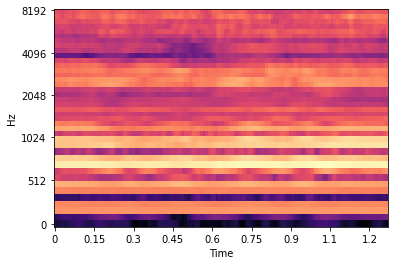

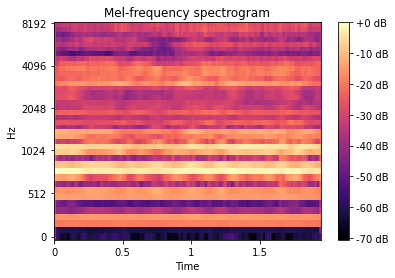

In [1]:
import os
import random
import librosa
import warnings
import numpy as np
from hparms import Processor_Hparams
from utils import same_seeds,segment,scaler,extract_phonation
warnings.filterwarnings('ignore')

def extract_feature_Melspec(hp:Processor_Hparams,wav_path):
    the_wavpath = str(wav_path)
    ## 将特征存储为numpy文件
    wavform,sr = librosa.load(the_wavpath)
    wavform = librosa.resample(wavform, orig_sr=sr, target_sr=hp.sample_rate)
    wavform,sr = librosa.effects.trim(wavform,top_db=hp.trim_db)  ## 静音消除
    wavform = librosa.effects.preemphasis(wavform, coef=hp.coef, zi=None)
    x_stft = librosa.stft(wavform,n_fft=hp.n_fft,hop_length=hp.hop_length,
        win_length=hp.win_length)
    spc = np.abs(x_stft).T
    mel_basis = librosa.filters.mel(sr=hp.sample_rate, n_fft=hp.n_fft, n_mels = hp.n_mels,
    fmin = hp.f_min, fmax=hp.f_max)
    fbank = np.log10(np.maximum(1e-8, np.dot(spc, mel_basis.T)))
    fbank = fbank.T
    melspec = librosa.feature.melspectrogram(wavform,sr=hp.sample_rate,hop_length=hp.hop_length,
    n_fft=hp.n_fft,win_length=hp.win_length,n_mels=hp.n_mels) ## 按照超参数进行mel提取
    mfcc = librosa.feature.mfcc(wavform, sr=hp.sample_rate, hop_length=hp.hop_length,
        n_fft=hp.n_fft,win_length=hp.win_length, n_mfcc=hp.n_mfcc)
    melspec = segment(melspec, seglen=hp.seglen)
    fbank = segment(fbank, seglen=hp.seglen)
    mfcc = segment(mfcc, seglen=hp.seglen)
    phonation_parms = extract_phonation(the_wavpath,seglen=hp.seglen)
    return melspec,mfcc,fbank,phonation_parms

hp = Processor_Hparams()
melspec,mfcc,fbank,phonation_parms = extract_feature_Melspec(hp,"./audios_and_mats/healthy/1-a_n.wav")
import matplotlib.pyplot as plt
import librosa.display
img = librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),sr=hp.sample_rate, hop_length=hp.hop_length,
fmax=8000, x_axis='time',y_axis='mel')

y, sr = librosa.load("./audios_and_mats/healthy/1-a_n.wav",sr=50000)
y_8k = librosa.resample(y, orig_sr=50000, target_sr=hp.sample_rate)
y_8k,_ = librosa.effects.trim(y_8k,top_db=hp.trim_db)  ## 静音消除
y_8k = librosa.effects.preemphasis(y_8k, coef=hp.coef, zi=None)
S = librosa.feature.melspectrogram(y=y_8k, sr=hp.sample_rate, n_mels=40,win_length=hp.win_length,hop_length=hp.hop_length,fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=hp.sample_rate,hop_length=hp.hop_length,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

melspec_phonation = scaler(np.concatenate((melspec,phonation_parms),axis=0))
melspec_phonation_2 = np.concatenate((scaler(melspec),scaler(phonation_parms)),axis=0)
mfcc_phonation = scaler(np.concatenate((mfcc,phonation_parms),axis=0))
mfcc_phonation_2 = np.concatenate((scaler(mfcc),scaler(phonation_parms)),axis=0)
fbank_phonation = scaler(np.concatenate((fbank,phonation_parms),axis=0))
fbank_phonation_2 = np.concatenate((scaler(fbank),scaler(phonation_parms)),axis=0)




In [1]:
from Model import CNN_BiLSTM
import torch
import onnx
import netron
from torchsummary import summary

model = CNN_BiLSTM(input_size=50,hidden_size=128,num_layers=2,num_classes=2)
dummy_input = torch.randn(32,1,128,50)  # 你模型的输入   NCHW
torch.onnx.export(model, dummy_input,'my_model.onnx', export_params=True,verbose=False,input_names=['input0'],output_names=['output0']) 
onnx_model = onnx.load('./my_model.onnx')  # load onnx model
netron.start("./my_model.onnx")
summary(model, dummy_input)
from tensorboardX import SummaryWriter
with SummaryWriter(logdir="network_visualization") as w:
    w.add_graph(model, dummy_input)


C:\Users\Alexanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
C:\Users\Alexanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C

Serving './my_model.onnx' at http://localhost:8080
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 128, 50]         800
├─MaxPool2d: 1-2                         [-1, 16, 64, 25]          --
├─Conv2d: 1-3                            [-1, 24, 64, 25]          18,840
├─MaxPool2d: 1-4                         [-1, 24, 32, 12]          --
├─Conv2d: 1-5                            [-1, 32, 32, 12]          37,664
├─MaxPool2d: 1-6                         [-1, 32, 16, 6]           --
├─LSTM: 1-7                              [-1, 16, 256]             724,992
├─Average_Weighted_Attention: 1-8        [-1, 256]                 256
├─Linear: 1-9                            [-1, 64]                  16,448
├─Dropout: 1-10                          [-1, 64]                  --
├─Linear: 1-11                           [-1, 2]                   130
Total params: 799,130
Trainable params: 799,130
Non-trainable params: 0
Total mult-a